# Indicator Adjusted Average (IAA) 

https://www.linnsoft.com/techind/indicator-adjusted-average-iia

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2020-01-01'
end = '2024-01-01'

# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.960472,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.251144,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.826859,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.484337,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.650352,132079200


In [3]:
minN = 10
maxN = 50

# Calculate daily returns
df['Return'] = df['Adj Close'].pct_change()

# Calculate rolling standard deviation (volatility) as the indicator
rolling_volatility = df['Return'].rolling(window=20).std()

# Calculate the min and max values of the indicator
minIND = rolling_volatility.min()
maxIND = rolling_volatility.max()

# Define a function to calculate the Indicator Adjusted Average
def calculate_IAA(df, maxN, minN, minIND, maxIND):
    df['Indicator'] = rolling_volatility
    df['Period'] = df['Indicator'].apply(lambda x: int(maxN - (x - minIND) * (maxN - minN) / (maxIND - minIND)) if pd.notna(x) else np.nan)
    df['IAA'] = df.apply(lambda row: df['Adj Close'].rolling(int(row['Period'])).mean().iloc[-1] if pd.notna(row['Period']) else np.nan, axis=1)
    return df

# Calculate the IAA
df = calculate_IAA(df, maxN, minN, minIND, maxIND)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Indicator,Period,IAA
Date,,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.960472,135480400,NaN,NaN,NaN,NaN
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.251144,146322800,-0.009722,NaN,NaN,NaN
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.826859,118387200,0.007968,NaN,NaN,NaN
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.484337,108872000,-0.004703,NaN,NaN,NaN
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.650352,132079200,0.016086,NaN,NaN,NaN


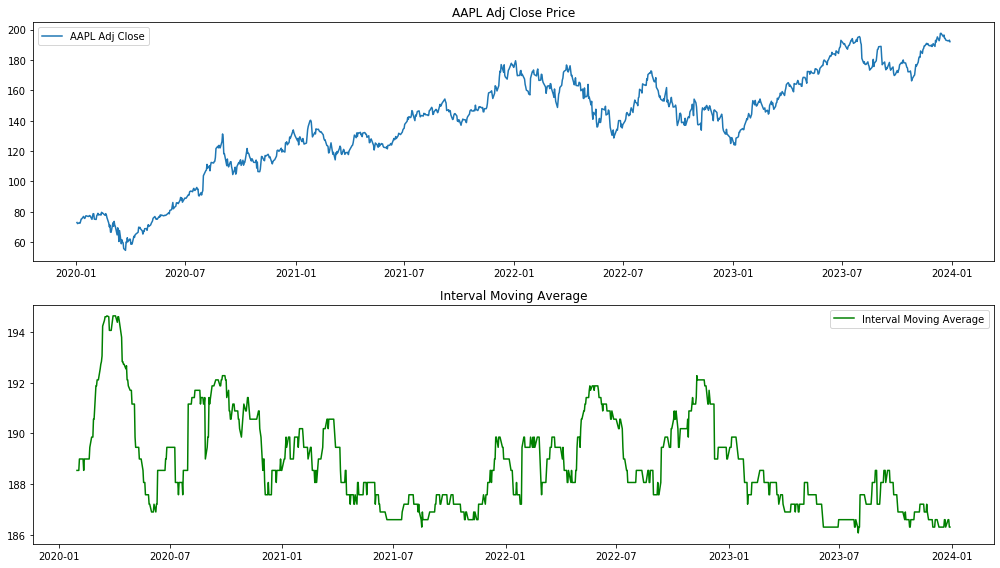

In [5]:
# Plotting
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['Adj Close'], label=f'{symbol} Adj Close')
plt.title(f'{symbol} Adj Close Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df.index, df['IAA'], label="Interval Moving Average", color='g')
# plt.axhline(0, color='red', linestyle='--')
plt.title("Interval Moving Average")
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## Candlestick with Indicator Adjusted Average

In [6]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Indicator,Period,IAA,VolumePositive
0,737426.0,74.059998,75.150002,73.797501,75.087502,72.960472,135480400,NaN,NaN,NaN,NaN,False
1,737427.0,74.287498,75.144997,74.125000,74.357498,72.251144,146322800,-0.009722,NaN,NaN,NaN,False
2,737430.0,73.447502,74.989998,73.187500,74.949997,72.826859,118387200,0.007968,NaN,NaN,NaN,False
3,737431.0,74.959999,75.224998,74.370003,74.597504,72.484337,108872000,-0.004703,NaN,NaN,NaN,False
4,737432.0,74.290001,76.110001,74.290001,75.797501,73.650352,132079200,0.016086,NaN,NaN,NaN,False


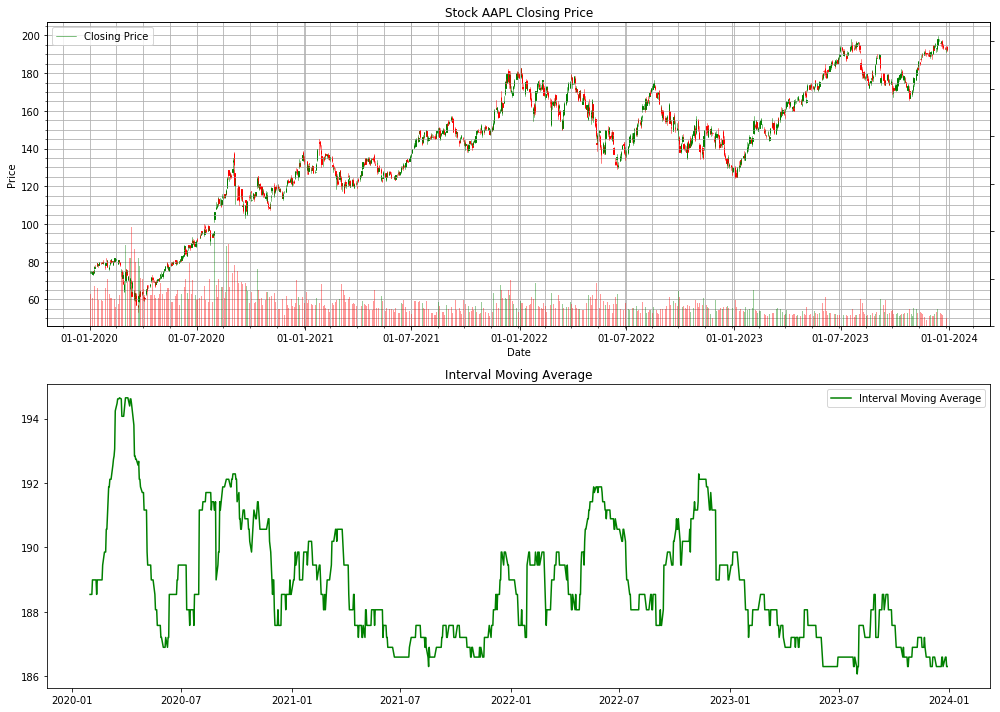

In [7]:
from mplfinance.original_flavor import candlestick_ohlc

fig = plt.figure(figsize=(14,10))

ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1, dfc[['Date', 'Open', 'High', 'Low', 'Close']].values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3 * dfc.Volume.max())

ax1.set_title('Stock ' + symbol + ' Closing Price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')
ax1.legend(['Closing Price'], loc='best')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df.index, df['IAA'], label="Interval Moving Average", color='g')
# plt.axhline(0, color='red', linestyle='--')
ax2.set_title("Interval Moving Average")
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

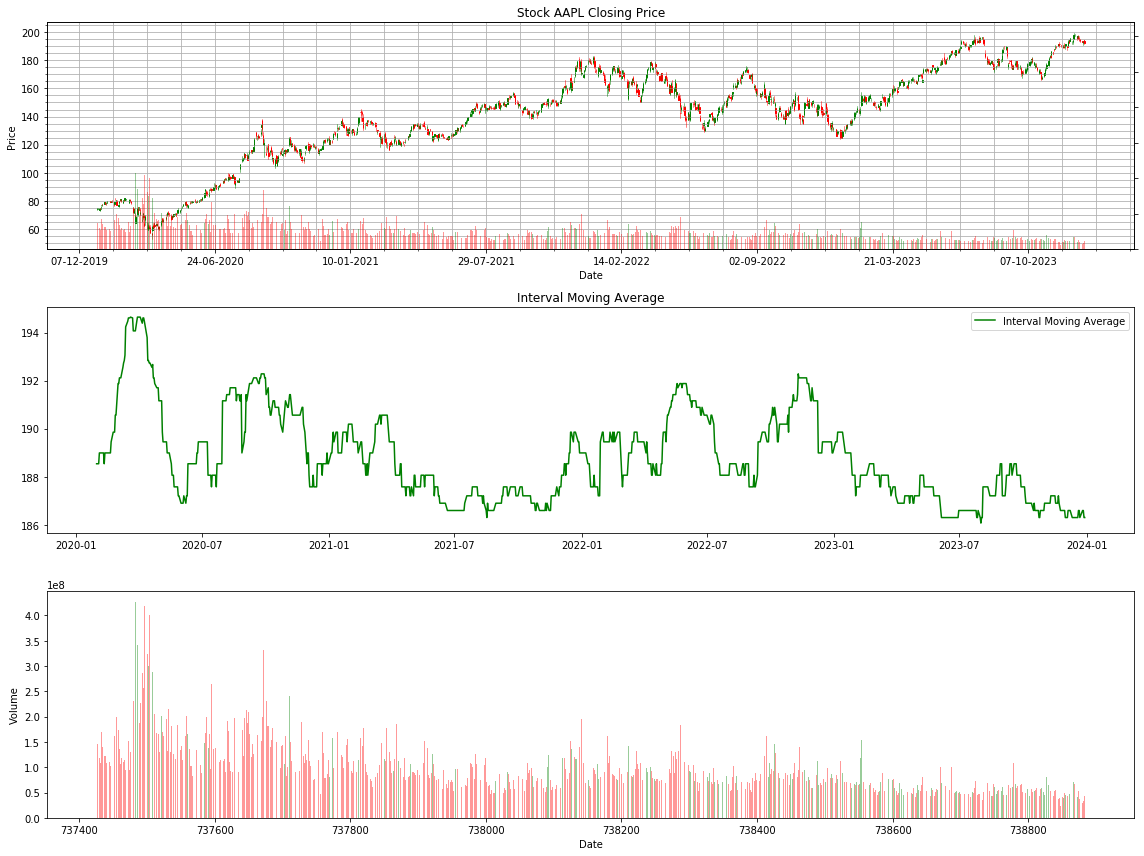

In [8]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(3, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

ax2 = plt.subplot(3, 1, 2)
ax2.plot(df.index, df['IAA'], label="Interval Moving Average", color='g')
# plt.axhline(0, color='red', linestyle='--')
ax2.set_title("Interval Moving Average")
ax2.legend(loc='best')

ax3 = plt.subplot(3, 1, 3)
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax3.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax3.set_ylabel('Volume')
ax3.set_xlabel('Date')

plt.tight_layout()
plt.show()